# setup

In [ ]:
tables = ['volcvg.csv']
mydrive= 'E:/mydoc/git/trade/analyics/'
# """
tables = ['volcvN.csv','volcvT.csv','volcvA.csv','volcvG.csv']
from google.colab import drive
drive.mount('/content/drive')
mydrive='/content/drive/MyDrive/volrt/'
# Requirements:
import os
if not os.path.exists('/usr/local/lib/python3.10/dist-packages/rtdl'):
  %pip install git+https://github.com/jerronl/rtdl.git
#"""

appname='Xcj_'
duration = 6
bad_value=-99999
vars_h, cat_names, ys,vars_c,= (
    ['date', 'diff', 'spot'],
    [],
    [[
        'close', 'hi', 'lo',
        'dtm','level','slope','curve',
         'dtm1','level1','slope1','curve1',
         'dtm2','level2','slope2','curve2',
         'dtm3','level3','slope3','curve3'],
         [ 'pmcat',],],
    ['Horizon','spot','time'],
)
import numpy as np

vars_h+=ys[0]
dep_vars=ys#[duration]
# vars_c=vars_c[duration]

ignore_load_zero=ignore_load_error=y_std=y_mean=X=y=loss_fn=my_model=jobsize=offset=start_epoch=optimizer=rand_seed = None

import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import rtdl.zero as zero
import matplotlib.pyplot as plt,os
%matplotlib inline
from typing import Optional
from torch import Tensor
import torch.nn as nn
import math
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from pickle import dump, load
import seaborn as sns
import random
from datetime import datetime
import calendar
import xlrd
from itertools import product
# !pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.13-cp38-cp38-linux_x86_64.whl --force-reinstall
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

device = torch.device('cuda')
zero.improve_reproducibility(seed=1234567)
batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*8
print(f'GPU mem:{int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)}G, batch_size:{batch_size}')


Mounted at /content/drive
  Cloning https://github.com/jerronl/rtdl.git to /tmp/pip-req-build-b4yuklpv
  Running command git clone --filter=blob:none --quiet https://github.com/jerronl/rtdl.git /tmp/pip-req-build-b4yuklpv
  Resolved https://github.com/jerronl/rtdl.git to commit f98ce61e5574c18e249a21e417e208f4832de808
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rtdl: filename=rtdl-0.0.14.dev0-py3-none-any.whl size=77961 sha256=91f8054f683105540602f71fbf6099c8714ff8390928627e3ebcf135b7b6fbf8
  Stored in directory: /tmp/pip-ephem-wheel-cache-otlxzppv/wheels/8d/92/7b/32aaeaca71d3de56c377bd2561972e24497e709ff9f9d967cc
Successfully built rtdl
GPU mem:16G, batch_size:128


# model

In [ ]:
def cyclic_encode(data,feature,original,period,names):
  data[f'sin_{feature}'] = np.sin(2 * np.pi * original/period)
  data[f'cos_{feature}'] = np.cos(2 * np.pi * original/period)
  names.extend([f'sin_{feature}',f'cos_{feature}'])

def get_cont_names(next_run=None):
  cont_names, dfo  = [f'{x[0]}_{x[1]+1}' for x in product(vars_h,range(duration))], pd.DataFrame()
  for table in tables:
      df = pd.read_csv(mydrive + table)
      if next_run:
        df=df.query(f'date>"#{next_run}"')
      df['source']=table
      dfo = pd.concat([dfo, df])
  dfo.sort_values(by=['date'],inplace=True)
  for cyclic in ['date_1','date_2','date_3','date_4','date_5','date_6']:
    cyclics=np.vectorize(lambda x: x.timetuple())(pd.to_datetime(dfo[cyclic], unit='D', origin='1899-12-30').astype('object'))
    cyclic_encode(dfo,f'y_{cyclic}',cyclics[7]-1,
      np.vectorize(lambda x: 365-28+calendar.monthrange(x,2)[1])(cyclics[0]),
      cont_names)
    cyclic_encode(dfo,f'm_{cyclic}',cyclics[2]-1,
      np.vectorize(lambda x,y: calendar.monthrange(x,y)[1])(cyclics[0],cyclics[1]),
      cont_names)
    cyclic_encode(dfo,f'w_{cyclic}',cyclics[6],7,cont_names)
  for cyclic in ['diff_1','diff_2','diff_3','diff_4','diff_5','diff_6']:
    cyclic_encode(dfo,cyclic,dfo[cyclic],70,cont_names)
  for cyclic in ['dtm_1','dtm_2','dtm_3','dtm_4','dtm_5','dtm_6']:
    cyclic_encode(dfo,cyclic,dfo[cyclic],5,cont_names)
  cont_names.sort()
  for cyclic in ['date']:
    cyclics=np.vectorize(lambda x: datetime(int(x[1:5]),int(x[6:8]),int(x[9:11]),int(x[12:14]),int(x[15:17]),int(x[18:20]),).timetuple())(dfo[cyclic])
    cyclic_encode(dfo,f'y_{cyclic}',cyclics[7]-1,
      np.vectorize(lambda x: 365-28+calendar.monthrange(x,2)[1])(cyclics[0]),
      cont_names)
    cyclic_encode(dfo,f'm_{cyclic}',cyclics[2]-1,
      np.vectorize(lambda x,y: calendar.monthrange(x,y)[1])(cyclics[0],cyclics[1]),
      cont_names)
    cyclic_encode(dfo,f'w_{cyclic}',cyclics[6],7,cont_names)
  assert len(cont_names) % 6==0
  dfo['time']=np.modf(dfo['date_6'])[0]
  return dfo, cont_names

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, position=None):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        if position is None:
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
class PETrans(nn.Module):

    def __init__(self, duration, d_model,n_num_features,cat_cardinalities,d_out,x2):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        print("PETrans",duration, d_model,n_num_features,cat_cardinalities,d_out,x2)
        super().__init__()
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Linear(duration, d_model*2), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Dropout(0.1), #self.hparams.input_dropout),
            nn.GELU(), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Linear(d_model*2, d_model), # self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.unf=nn.Flatten(1,2)
        self.ftt= rtdl.FTTransformer.make_default(
            n_num_features=int(n_num_features/duration*d_model+x2),
            cat_cardinalities=cat_cardinalities,
            d_out=d_out,
            )

    def forward(self, x_num: Optional[Tensor], x_cat: Optional[Tensor], x2: Optional[Tensor]) -> Tensor:
        x = self.input_net(x_num)
        x = self.positional_encoding(x)
        x = self.unf(x)
        x = torch.cat((x, x2), 1)
        x = self.ftt(x, x_cat)
        return x

    def make_default_optimizer(self) -> torch.optim.AdamW:
        """Make the optimizer for the default FT-Transformer."""
        return self.ftt.make_default_optimizer()

def apply_model(model, x_num, x_cat=None, x2=None):
    return model(x_num, x_cat, x2)

@torch.no_grad()
def evaluate(mload=None,part='val'):
    model=mload or my_model
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], batch_size):
        prediction.append(apply_model(model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y[part]
    prediction2 = prediction[:,-y_cat:].argmax(1)
    mask = ~torch.isnan(target[:,:-1])
    score = (F.mse_loss(prediction[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
          ((target[:,-1]!=prediction2).sum()/len(prediction))

    return score,target, prediction,prediction2

def plot_result(target, prediction, prediction2, compare=False):
  sns.jointplot(x=target[:,-1] , y=prediction2,kind="kde",fill=True,rug=True)
  prediction[:,-y_cat]=prediction2
  sns.set(style="whitegrid")
  print(f'mse={np.mean((target[:,-1] - prediction2)**2)}')
  dep_var=dep_vars[0]+dep_vars[1]
  figs=min(len(dep_var),4)
  _, axes = plt.subplots(math.ceil(len(dep_var)/figs), figs, figsize=(16,16))
  for i,name in enumerate(dep_var):
      axs=axes.flat[i] if figs>1 else axes
      sns.regplot(ax=axs, x=target[:,i] , y=prediction[:,i],
                scatter_kws = {'color': 'purple', 'alpha': 0.3},
                line_kws = {'color': '#CCCC00', 'alpha': 0.3}
                )
      axs.set_title(name)
      mask=~np.isnan(target[:,i])
      if len(target[:,i][mask])>0:
        if not dep_var[i][:3] in ['dtm','pmc']:

          axs.set_xlim(left=max(np.min(target[:,i][mask]), -2.5),
                        right=min(np.max(target[:,i][mask]),2.5))
        else:
          axs.set_xlim(left=np.min(target[:,i][mask]),
                              right=np.max(target[:,i][mask]))
  plt.show()
  if compare:
    for i,name in enumerate(dep_var):
      if not dep_var[i][:3] in ['dtm','pmc']:
        plt.plot(target[:,i],label=f'actual {name}')
        plt.plot(prediction[:,i],label=f'forecast {name}')
        plt.legend()
        plt.show()

@torch.no_grad()
def validate(mload=None, threshold=10):
  score,target, prediction,prediction2 = evaluate(mload,'test')
  print(jobname,f'{score:.4f}')
  if score>threshold:
    return
  target, prediction, prediction2 = target.squeeze(1).cpu().numpy(), prediction.squeeze(1).cpu().numpy(), prediction2.cpu().numpy()
  plot_result(target, prediction,prediction2)

def cross_entropy_mse_loss_with_nans(input, target):
    mask = ~torch.isnan(target[:,:-1])
    return (F.mse_loss(input[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
      (F.cross_entropy (input[:,-y_cat:],target[:,-1].type(torch.LongTensor).to(device)))

def model_path():
  return mydrive+jobname+'checkpoint.pt'

def save_model(improved=False):
  path=mydrive+jobname+'checkpoint.pt'
  torch.save(
      {
          'model_':  my_model.state_dict() if improved or not os.path.exists(path) else
                    torch.load(path)['model_'],
          'model'       : my_model.state_dict(),
          'optimizer'   : optimizer.state_dict(),
          'epoch'       : epoch,
          'random_state': zero.random.get_state (),
          'jobsize'     : jobsize,
          'offset'      : offset,
          'rand_seed'    : rand_seed,
      },
      path
  )

def load_model(load_good=False,keep_seed=True):
  global jobsize,offset,start_epoch,my_model,optimizer,rand_seed
  start_epoch=1
  jobsize=int(len(X_all)*0.1)
  if resume:
    path=mydrive+jobname+'checkpoint.pt'
    if os.path.exists(path):
      try:
        checkpoint = torch.load(path,map_location=device)
        my_model.load_state_dict(checkpoint['model_'if load_good else 'model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        if 'rand_seed' in checkpoint and keep_seed:
          rand_seed=checkpoint['rand_seed']
        try:
          zero.random.set_state(checkpoint['random_state'])
        except (AssertionError,) as err:
          if ignore_load_zero:
            print("zero error:",err)
          else:
            raise err
        print(f'loaded {jobname} epoch {start_epoch}')
        if 'jobsize' in checkpoint and checkpoint['jobsize']<=jobsize:
          offset=checkpoint['offset']
          if checkpoint['jobsize']<jobsize:
            print('Job size increased from ', checkpoint['jobsize'], ' to ', jobsize)
            if offset<0:
              offset+=checkpoint['jobsize']*10
        else:
          raise ValueError('size diffs now',jobsize,
                checkpoint['jobsize'] if 'jobsize' in checkpoint else 0)
        return True
      except Exception as error:
        if ignore_load_error:
          print("failed to load: ", error)
        else:
          raise error
  random.seed(datetime.now().timestamp())
  offset=random.randint(-jobsize*3,-jobsize*2)+jobsize*10
  return False

def job_name():
  return appname+''.join(filter(lambda x: x not in "[' ", str(dep_vars[0])))[:8]

def setup_data(mis=False):
  global jobname,X,y, my_model,optimizer,train_loader,progress,y_mean,y_std,loss_fn,y_cat,rand_seed
  dep_var=dep_vars[0]+dep_vars[1]
  jobname=job_name()
  y_all=torch.tensor(dfo.loc[:,dep_var].to_numpy(), device=device)

  y_cat = 22#int(max(y_all[:,-1]))
  y_all[:,-1]-=1
  d_out = y_cat+y_all.shape[1]-1

  X,y = {},{}
  my_model=PETrans(
      duration=duration,
      d_model=16,
      n_num_features=len(cont_names),
      cat_cardinalities=[len(arr) for arr in enc.categories_],
      d_out=d_out,
      x2=len(vars_c)
      ).to(device)

  optimizer = (
      my_model.make_default_optimizer()
  )
  load_model(load_good=mis,keep_seed= not mis)

  X['train'], X['test'], y['train'], y['test']  = (
      np.concatenate((X_all[:offset],X_all[offset+jobsize:])),
      X_all[offset:offset+jobsize],
      torch.cat((y_all[:offset],y_all[offset+jobsize:])),
      y_all[offset:offset+jobsize],
  )
  if rand_seed is None:
    rand_seed=np.random.default_rng().integers(99999)
  print(jobname,y_all.shape,'offset ',offset,dfo['date'].iloc[offset],'seed', rand_seed)
  X['train'], X['val'],  y['train'], y['val']  = sklearn.model_selection.train_test_split(
      X['train'], y['train'], train_size=0.95, random_state=rand_seed
  )
  X2, X['test'], y2, y['test']  = sklearn.model_selection.train_test_split(
      X['test'], y['test'], train_size=0.05, random_state=rand_seed
  )
  X['val'], y['val']=np.concatenate((X['val'], X['test'])),torch.cat(( y['val'], y['test']))
  X['train'], y['train']=np.concatenate((X['train'], X2)),torch.cat(( y['train'], y2))

  X = {
      k: (torch.tensor(v[:,:len(cat_names)], device=device).to(torch.int64),
          torch.tensor(v[:,-len(cont_names):].reshape((v.shape[0],int(len(cont_names)/duration),duration)), device=device),
          torch.tensor(v[:,len(cat_names):-len(cont_names)], device=device),)
      for k, v in X.items()
  }
  # y = {k: torch.tensor(v, device=device) for k, v in y.items()}
  mask=torch.masked.masked_tensor(y['train'],y['train']!=bad_value)
  y_mean,y_std=mask.mean(dim=0).to_tensor(0),mask.std(dim=0).to_tensor(0)
  cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
  for k,v in y.items():
    v[v==bad_value]=float('nan')
    v[:,cols_to_norm]=((v-y_mean) / y_std)[:,cols_to_norm]
    y[k]=v


  y = {k: v.float() for k, v in y.items()}

  train_loader = zero.data.IndexLoader(len(X['train'][0]), batch_size, device=device)
  progress = zero.ProgressTracker(patience=100)
  loss_fn = cross_entropy_mse_loss_with_nans

def boxplot(vars,bad_value=None):
  i=j=min(5,len(vars))
  for _,var in enumerate(vars):
      if isinstance(var,list):
        y=pd.Series()
        for name in var:
          if name in dfo.columns:
            y=y.append(dfo[name],ignore_index = True)
      else:
        y=dfo[var] if var in dfo.columns else []
        name=var
      if len(y)>0:
        if i>=j:
          figure, axes = plt.subplots(1,j,figsize=(16,8))
          i=0
        axs=axes.flat[i]
        i+=1
        if bad_value is not None and y.min()<=bad_value:
          mask=y!=bad_value
          name=f'{name}_{mask.sum()/len(mask):.0%}'
          y=y[mask]
        sns.boxplot(ax=axs, y=y, showmeans=True,
                          meanprops={"marker": "+",
                        "markeredgecolor": "black",
                        "markersize": "10"})
        axs.set_title(name)
  plt.show()


def set_state(state: Dict[str, Any]) -> None:
    """Set global random states in `random`, `numpy` and `torch`.

    Args:
        state: global RNG states. Must be produced by `get_state`. The size of the list
            :code:`state['torch.cuda']` must be equal to the number of available cuda
            devices.

    See also:
        `get_state`

    Raises:
        AssertionError: if :code:`torch.cuda.device_count() != len(state['torch.cuda'])`
    """
    random.setstate(state['random'])
    np.random.set_state(state['numpy.random'])
    torch.random.set_rng_state(state['torch.random'].cpu())
    assert torch.cuda.device_count() == len(state['torch.cuda'])
    torch.cuda.set_rng_state_all([v.cpu() for v in state['torch.cuda']])  # type: ignore

zero.random.set_state=set_state


In [ ]:
import gc

my_model.cpu()
del my_model
gc.collect()
torch.cuda.empty_cache()






# Training

In [ ]:
# next_dep = 0
# next_dep=1
# next_dep=2
# next_dep=3
resume = True  # False#
# tables = ['volcva.csv']
# tables = ['volcvN.csv','volcvT.csv','volcvA.csv','volcvG.csv']
dfo, cont_names=get_cont_names()

# dfo.sort_values(by=['date'],inplace=True)
enc = OrdinalEncoder()
dfo[cat_names] = enc.fit_transform(dfo[cat_names])
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')

print(dfo.shape, X_all.shape,len(dep_vars[0]))
zero_perc=(1-len(dfo[dfo['close']>0])/len(dfo)+len(dfo[dfo['close']<0])/len(dfo))/2
print(zero_perc,dfo['close'].quantile([0]+[i*(zero_perc-0.005)/9.5+0.005 for i in range(10)]+[0.995-(0.995-zero_perc)/10.5*(21-i) for i in range(11,22)]+[1]))
boxplot(vars_h[1:],bad_value)
boxplot([[f'{var}_{i+1}' for i in range(duration)] for var in vars_h[1:]],0)


In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[dfo['spot']>15].iloc[0])

# run


In [ ]:
next_dep=0
# resume=False#s
# resume=True#False#
# ignore_load_error=True
# ignore_load_zero=True

n_epochs = 2000
n_trials = 80
start_epoch = 1
sub_epochs=15

for dep_sec in range(next_dep, len(dep_vars)):
    n_no_improve = 0
    setup_data()
    print(X['train'][0].shape, X['train'][1].shape, y['train'].shape)
    validate()
    resume=True
    # report_frequency = len(X['train']) // batch_size // 5
    for epoc in range(start_epoch, n_epochs , sub_epochs):
      for epoch in range(epoc,epoc+sub_epochs):
        for iteration, batch_idx in enumerate(train_loader):
            my_model.train()
            optimizer.zero_grad()
            x_batch = (X['train'][0][batch_idx] if len(cat_names)>0 else None,
                       X['train'][1][batch_idx],
                       X['train'][2][batch_idx])
            y_batch = y['train'][batch_idx]
            loss = loss_fn(
                apply_model(my_model,
                            x_cat=x_batch[0] if len(cat_names)>0 else None,
                            x_num=x_batch[1], x2=x_batch[2]).squeeze(1),
                y_batch)
            loss.backward()
            optimizer.step()
            # if iteration % report_frequency == 0:
            #     print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

        val_score = evaluate()[0]
        # test_score = evaluate(my_model,'test')[0]
        print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f}', end=" ")
        progress.update(-val_score)
        if progress.success:
            print(' <<< BEST VALIDATION EPOCH')
            save_model(True)
            n_no_improve = 0
        else:
            # save_model(False)
            n_no_improve += 1
            print(f' no improve {n_no_improve}')
        if progress.fail or val_score < .01 or n_no_improve > n_trials:
            break
      if progress.fail or val_score < .01 or n_no_improve > n_trials:
        break
      if n_no_improve>sub_epochs:
        setup_data(True)
    # load_model()
    with open(mydrive + jobname, 'wb') as filehandler:
        dump((my_model, y_std, y_mean, enc), filehandler)
    validate()

## manual

In [ ]:
    #my_model, y_std, y_mean, enc = models
    # setup_data(0)
    prediction = []
    i=0
    with torch.no_grad():
      my_model.eval()
      for batch in zero.iter_batches(X['test'], batch_size):
      # batch=next(zero.iter_batches(X['test'], batch_size))
      # if True:
        prediction.append(apply_model(my_model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y['test']#[i:i+batch_size]
    if task_type == 'binclass':
      prediction = np.round(scipy.special.expit(prediction))
      score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
      prediction = prediction.argmax(1)
      score = (target.reshape(-1)!=prediction).sum()/len(prediction)
    else:
      assert task_type == 'regression'
      score =mse_loss_with_nans(prediction, target, ) ** 0.5

    score,target, prediction


In [ ]:
for i in range(len(target)):
  if target[i][0]==1 and prediction[i][0]>2:
    print(i,target[i],prediction[i])

In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[(dfo['dtm']==1)&(dfo['diff_1']==19)&(dfo['dtm_1']==10)&(dfo['Horizon']<4)].iloc[10])

In [ ]:
validate()

## export

In [ ]:
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')
resume=True
ignore_load_zero=True
ignore_load_error=True

if len(dep_vars)>0:
  setup_data()
  with open(mydrive + jobname, 'wb') as filehandler:
      dump((my_model, y_std, y_mean, enc), filehandler)


Xci_close,hi torch.Size([17580, 20])
PETrans 6 16 198 [] 41 2
loaded Xci_close,hi epoch 335
failed to load:  ('size diffs now', 1758, 25763)
offset  12585


# valid

In [ ]:
last_run = "2023-12-17"
next_run = "2023-10-30"

def val_period(periods,source=None):
    global jobname, X, y, my_model, y_mean, y_std
    for period in periods:
      print(period,'========================================================')
      df = dfo.query(f'date>"#{period[0]}" and date<"#{period[1]}"')
      if source:
        df=df[df['source']==source]
      if len(df)<1:
        return
      df.sort_values(by=['Horizon'],inplace=True)
      dep_var=dep_vars[0]+dep_vars[1]
      X, y = ({'test':
                (  # dfo.loc[:,cat_names+vars_c+cont_names].to_numpy().astype('float32')},{}
                    torch.tensor(df.loc[:, cat_names].to_numpy(), device=device).to(torch.int64),
                    torch.tensor(df.loc[:, cont_names].to_numpy().astype('float32').reshape((df.shape[0], int(len(cont_names) / duration), duration)), device=device),
                    torch.tensor(df.loc[:, vars_c].to_numpy().astype('float32'), device=device),
                )
                }, {'test': torch.tensor(df.loc[:,dep_var].to_numpy(), device=device).float()})
      print('duration: ', duration,df.shape, X['test'][0].shape, X['test'][1].shape, X['test'][2].shape)
      y['test'][:,-1]-=1

      #for learner in models:
      jobname = job_name()
      my_model, y_std, y_mean, enc = models
      y['test'][y['test']==bad_value]=float('nan')
      cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
      y['test'][:,cols_to_norm]=((y['test']-y_mean) / y_std)[:,cols_to_norm].float()
      score,target, prediction,prediction2 = evaluate(my_model,'test')
      print("score",score)
      if score<20:
        target, prediction, prediction2 = target.squeeze(1).cpu().numpy(), prediction.squeeze(1).cpu().numpy(), prediction2.cpu().numpy()
        plot_result(target, prediction,prediction2)
        if period[1]=='9999' or source is not None:
          count=df.groupby(['Horizon'])['Horizon'].count().sort_index().cumsum()
          count[-1]=0
          mask=~np.isnan(target[:,:-1])
          for h in range(6):
            t,p,p2,m=target[count[h-1]:count[h],:], prediction[count[h-1]:count[h],:],prediction2[count[h-1]:count[h]],mask[count[h-1]:count[h],:]
            if len(t)>10:
              score = ((p[:,:-y_cat][m]-t[:,:-1][m])**2).mean()**.5*10+\
                      ((t[:,-1]!=p2).sum()/len(p))
              print ('Horizon: ',h,'\tScore:',score,len(t))
              plot_result(t,p,p2,source is not None)

In [ ]:
# dfo, cont_names = get_cont_names()
# path=f'{mydrive}Xcj_close,hicheckpoint.pt'
dfo.sort_values(by=['date'],inplace=True)
path=mydrive+jobname+'checkpoint.pt'
checkpoint = torch.load(path,map_location=device)
offset,jobsize=checkpoint['offset'],checkpoint['jobsize']
start,end=dfo['date'].iloc[offset],dfo['date'].iloc[offset+jobsize],
print(f"epoch {checkpoint['epoch']} jobsize {jobsize} to {len(dfo)//10} offset {start} {end}")
print(dfo.iloc[offset:offset+jobsize][['date','source','Horizon']])


epoch 29 jobsize 27099 to 27099 offset #2023-08-18 15:49:52# #2023-10-05 11:02:01#
                         date      source  Horizon
33244   #2023-08-18 15:49:52#  volcvA.csv        2
33226   #2023-08-18 15:49:52#  volcvA.csv        2
33495   #2023-08-18 15:49:52#  volcvA.csv        1
32335   #2023-08-18 15:49:52#  volcvA.csv        5
32605   #2023-08-18 15:49:52#  volcvA.csv        5
...                       ...         ...      ...
106920  #2023-10-05 11:02:01#  volcvT.csv        5
108198  #2023-10-05 11:02:01#  volcvT.csv        1
106822  #2023-10-05 11:02:01#  volcvT.csv        5
107338  #2023-10-05 11:02:01#  volcvT.csv        4
107726  #2023-10-05 11:02:01#  volcvT.csv        2

[27099 rows x 3 columns]


In [ ]:
# jobname = 'Xcj_close,hi'
jobname = job_name()
with open(f'{mydrive}/{jobname}', 'rb') as filehandler:
    models=load(filehandler)

dfo, cont_names = get_cont_names()

dfo['day']=dfo['date_6'].astype(int)
lastday=dfo.groupby(['day','source'])['date_6'].transform(max)
dfo=dfo[dfo['date_6']>lastday-0.02]

enc=models[3]
dfo[cat_names] = enc.fit_transform(dfo[cat_names])

y_cat=22
for table in tables:
  print(table)
  val_period( [['2023-01-06','2023-01-20']],table)

## before

In [ ]:
last_run = "2023-12-17"
next_run = "2023-10-30"

tables = ['volcvg.csv']
mydrive= 'E:/mydoc/git/trade/analyics/'
# """
tables = ['volcvN.csv','volcvT.csv','volcvA.csv','volcvG.csv']
from google.colab import drive
drive.mount('/content/drive')
mydrive='/content/drive/MyDrive/volrt/'
# Requirements:
import os
if not os.path.exists('/usr/local/lib/python3.10/dist-packages/rtdl'):
  %pip install git+https://github.com/jerronl/rtdl.git
#"""

appname='Xcj_'
duration = 6
bad_value=-99999
vars_h, cat_names, ys,vars_c,= (
    ['date', 'diff', 'spot'],
    [],
    [[
        'close', 'hi', 'lo',
        'dtm','level','slope','curve',
         'dtm1','level1','slope1','curve1',
         'dtm2','level2','slope2','curve2',
         'dtm3','level3','slope3','curve3'],
         [ 'pmcat',],],
    ['Horizon','spot','time'],
)
import numpy as np

vars_h+=ys[0]
dep_vars=ys#[duration]
# vars_c=vars_c[duration]

ignore_load_zero=ignore_load_error=y_std=y_mean=X=y=loss_fn=my_model=jobsize=offset=start_epoch=optimizer=rand_seed = None

import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import rtdl.zero as zero
import matplotlib.pyplot as plt,os
%matplotlib inline
from typing import Optional
from torch import Tensor
import torch.nn as nn
import math
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from pickle import dump, load
import seaborn as sns
import random
from datetime import datetime
import calendar
import xlrd
from itertools import product
# !pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.13-cp38-cp38-linux_x86_64.whl --force-reinstall
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

device = torch.device('cuda')
zero.improve_reproducibility(seed=1234567)
batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*8
print(f'GPU mem:{int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)}G, batch_size:{batch_size}')

# =======================================================model=========================================
def cyclic_encode(data,feature,original,period,names):
  data[f'sin_{feature}'] = np.sin(2 * np.pi * original/period)
  data[f'cos_{feature}'] = np.cos(2 * np.pi * original/period)
  names.extend([f'sin_{feature}',f'cos_{feature}'])

def get_cont_names(next_run=None):
  cont_names, dfo  = [f'{x[0]}_{x[1]+1}' for x in product(vars_h,range(duration))], pd.DataFrame()
  for table in tables:
      df = pd.read_csv(mydrive + table)
      if next_run:
        df=df.query(f'date>"#{next_run}"')
      df['source']=table
      dfo = pd.concat([dfo, df])
  dfo.sort_values(by=['date'],inplace=True)
  for cyclic in ['date_1','date_2','date_3','date_4','date_5','date_6']:
    cyclics=np.vectorize(lambda x: x.timetuple())(pd.to_datetime(dfo[cyclic], unit='D', origin='1899-12-30').astype('object'))
    cyclic_encode(dfo,f'y_{cyclic}',cyclics[7]-1,
      np.vectorize(lambda x: 365-28+calendar.monthrange(x,2)[1])(cyclics[0]),
      cont_names)
    cyclic_encode(dfo,f'm_{cyclic}',cyclics[2]-1,
      np.vectorize(lambda x,y: calendar.monthrange(x,y)[1])(cyclics[0],cyclics[1]),
      cont_names)
    cyclic_encode(dfo,f'w_{cyclic}',cyclics[6],7,cont_names)
  for cyclic in ['diff_1','diff_2','diff_3','diff_4','diff_5','diff_6']:
    cyclic_encode(dfo,cyclic,dfo[cyclic],70,cont_names)
  for cyclic in ['dtm_1','dtm_2','dtm_3','dtm_4','dtm_5','dtm_6']:
    cyclic_encode(dfo,cyclic,dfo[cyclic],5,cont_names)
  cont_names.sort()
  for cyclic in ['date']:
    cyclics=np.vectorize(lambda x: datetime(int(x[1:5]),int(x[6:8]),int(x[9:11]),int(x[12:14]),int(x[15:17]),int(x[18:20]),).timetuple())(dfo[cyclic])
    cyclic_encode(dfo,f'y_{cyclic}',cyclics[7]-1,
      np.vectorize(lambda x: 365-28+calendar.monthrange(x,2)[1])(cyclics[0]),
      cont_names)
    cyclic_encode(dfo,f'm_{cyclic}',cyclics[2]-1,
      np.vectorize(lambda x,y: calendar.monthrange(x,y)[1])(cyclics[0],cyclics[1]),
      cont_names)
    cyclic_encode(dfo,f'w_{cyclic}',cyclics[6],7,cont_names)
  assert len(cont_names) % 6==0
  dfo['time']=np.modf(dfo['date_6'])[0]
  return dfo, cont_names

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, position=None):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        if position is None:
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
class PETrans(nn.Module):

    def __init__(self, duration, d_model,n_num_features,cat_cardinalities,d_out,x2):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        print("PETrans",duration, d_model,n_num_features,cat_cardinalities,d_out,x2)
        super().__init__()
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Linear(duration, d_model*2), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Dropout(0.1), #self.hparams.input_dropout),
            nn.GELU(), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Linear(d_model*2, d_model), # self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.unf=nn.Flatten(1,2)
        self.ftt= rtdl.FTTransformer.make_default(
            n_num_features=int(n_num_features/duration*d_model+x2),
            cat_cardinalities=cat_cardinalities,
            d_out=d_out,
            )

    def forward(self, x_num: Optional[Tensor], x_cat: Optional[Tensor], x2: Optional[Tensor]) -> Tensor:
        x = self.input_net(x_num)
        x = self.positional_encoding(x)
        x = self.unf(x)
        x = torch.cat((x, x2), 1)
        x = self.ftt(x, x_cat)
        return x

    def make_default_optimizer(self) -> torch.optim.AdamW:
        """Make the optimizer for the default FT-Transformer."""
        return self.ftt.make_default_optimizer()

def apply_model(model, x_num, x_cat=None, x2=None):
    return model(x_num, x_cat, x2)

@torch.no_grad()
def evaluate(mload=None,part='val'):
    model=mload or my_model
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], batch_size):
        prediction.append(apply_model(model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y[part]
    prediction2 = prediction[:,-y_cat:].argmax(1)
    mask = ~torch.isnan(target[:,:-1])
    score = (F.mse_loss(prediction[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
          ((target[:,-1]!=prediction2).sum()/len(prediction))

    return score,target, prediction,prediction2

def plot_result(target, prediction, prediction2, compare=False):
  sns.jointplot(x=target[:,-1] , y=prediction2,kind="kde",fill=True,rug=True)
  prediction[:,-y_cat]=prediction2
  sns.set(style="whitegrid")
  print(f'mse={np.mean((target[:,-1] - prediction2)**2)}')
  dep_var=dep_vars[0]+dep_vars[1]
  figs=min(len(dep_var),4)
  _, axes = plt.subplots(math.ceil(len(dep_var)/figs), figs, figsize=(16,16))
  for i,name in enumerate(dep_var):
      axs=axes.flat[i] if figs>1 else axes
      sns.regplot(ax=axs, x=target[:,i] , y=prediction[:,i],
                scatter_kws = {'color': 'purple', 'alpha': 0.3},
                line_kws = {'color': '#CCCC00', 'alpha': 0.3}
                )
      axs.set_title(name)
      mask=~np.isnan(target[:,i])
      if len(target[:,i][mask])>0:
        if not dep_var[i][:3] in ['dtm','pmc']:

          axs.set_xlim(left=max(np.min(target[:,i][mask]), -2.5),
                        right=min(np.max(target[:,i][mask]),2.5))
        else:
          axs.set_xlim(left=np.min(target[:,i][mask]),
                              right=np.max(target[:,i][mask]))
  plt.show()
  if compare:
    for i,name in enumerate(dep_var):
      if not dep_var[i][:3] in ['dtm','pmc']:
        plt.plot(target[:,i],label=f'actual {name}')
        plt.plot(prediction[:,i],label=f'forecast {name}')
        plt.legend()
        plt.show()

@torch.no_grad()
def validate(mload=None, threshold=10):
  score,target, prediction,prediction2 = evaluate(mload,'test')
  print(jobname,f'{score:.4f}')
  if score>threshold:
    return
  target, prediction, prediction2 = target.squeeze(1).cpu().numpy(), prediction.squeeze(1).cpu().numpy(), prediction2.cpu().numpy()
  plot_result(target, prediction,prediction2)

def cross_entropy_mse_loss_with_nans(input, target):
    mask = ~torch.isnan(target[:,:-1])
    return (F.mse_loss(input[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
      (F.cross_entropy (input[:,-y_cat:],target[:,-1].type(torch.LongTensor).to(device)))

def model_path():
  return mydrive+jobname+'checkpoint.pt'

def save_model(improved=False):
  path=mydrive+jobname+'checkpoint.pt'
  torch.save(
      {
          'model_':  my_model.state_dict() if improved or not os.path.exists(path) else
                    torch.load(path)['model_'],
          'model'       : my_model.state_dict(),
          'optimizer'   : optimizer.state_dict(),
          'epoch'       : epoch,
          'random_state': zero.random.get_state (),
          'jobsize'     : jobsize,
          'offset'      : offset,
          'rand_seed'    : rand_seed,
      },
      path
  )

def load_model(load_good=False,keep_seed=True):
  global jobsize,offset,start_epoch,my_model,optimizer,rand_seed
  start_epoch=1
  jobsize=int(len(X_all)*0.1)
  if resume:
    path=mydrive+jobname+'checkpoint.pt'
    if os.path.exists(path):
      try:
        checkpoint = torch.load(path,map_location=device)
        my_model.load_state_dict(checkpoint['model_'if load_good else 'model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        if 'rand_seed' in checkpoint and keep_seed:
          rand_seed=checkpoint['rand_seed']
        try:
          zero.random.set_state(checkpoint['random_state'])
        except (AssertionError,) as err:
          if ignore_load_zero:
            print("zero error:",err)
          else:
            raise err
        print(f'loaded {jobname} epoch {start_epoch}')
        if 'jobsize' in checkpoint and checkpoint['jobsize']<=jobsize:
          offset=checkpoint['offset']
          if checkpoint['jobsize']<jobsize:
            print('Job size increased from ', checkpoint['jobsize'], ' to ', jobsize)
            if offset<0:
              offset+=checkpoint['jobsize']*10
        else:
          raise ValueError('size diffs now',jobsize,
                checkpoint['jobsize'] if 'jobsize' in checkpoint else 0)
        return True
      except Exception as error:
        if ignore_load_error:
          print("failed to load: ", error)
        else:
          raise error
  random.seed(datetime.now().timestamp())
  offset=random.randint(-jobsize*3,-jobsize*2)+jobsize*10
  return False

def job_name():
  return appname+''.join(filter(lambda x: x not in "[' ", str(dep_vars[0])))[:8]

def setup_data(mis=False):
  global jobname,X,y, my_model,optimizer,train_loader,progress,y_mean,y_std,loss_fn,y_cat,rand_seed
  dep_var=dep_vars[0]+dep_vars[1]
  jobname=job_name()
  y_all=torch.tensor(dfo.loc[:,dep_var].to_numpy(), device=device)

  y_cat = 22#int(max(y_all[:,-1]))
  y_all[:,-1]-=1
  d_out = y_cat+y_all.shape[1]-1

  X,y = {},{}
  my_model=PETrans(
      duration=duration,
      d_model=16,
      n_num_features=len(cont_names),
      cat_cardinalities=[len(arr) for arr in enc.categories_],
      d_out=d_out,
      x2=len(vars_c)
      ).to(device)

  optimizer = (
      my_model.make_default_optimizer()
  )
  load_model(load_good=mis,keep_seed= not mis)

  X['train'], X['test'], y['train'], y['test']  = (
      np.concatenate((X_all[:offset],X_all[offset+jobsize:])),
      X_all[offset:offset+jobsize],
      torch.cat((y_all[:offset],y_all[offset+jobsize:])),
      y_all[offset:offset+jobsize],
  )
  if rand_seed is None:
    rand_seed=np.random.default_rng().integers(99999)
  print(jobname,y_all.shape,'offset ',offset,dfo['date'].iloc[offset],'seed', rand_seed)
  X['train'], X['val'],  y['train'], y['val']  = sklearn.model_selection.train_test_split(
      X['train'], y['train'], train_size=0.95, random_state=rand_seed
  )
  X2, X['test'], y2, y['test']  = sklearn.model_selection.train_test_split(
      X['test'], y['test'], train_size=0.05, random_state=rand_seed
  )
  X['val'], y['val']=np.concatenate((X['val'], X['test'])),torch.cat(( y['val'], y['test']))
  X['train'], y['train']=np.concatenate((X['train'], X2)),torch.cat(( y['train'], y2))

  X = {
      k: (torch.tensor(v[:,:len(cat_names)], device=device).to(torch.int64),
          torch.tensor(v[:,-len(cont_names):].reshape((v.shape[0],int(len(cont_names)/duration),duration)), device=device),
          torch.tensor(v[:,len(cat_names):-len(cont_names)], device=device),)
      for k, v in X.items()
  }
  # y = {k: torch.tensor(v, device=device) for k, v in y.items()}
  mask=torch.masked.masked_tensor(y['train'],y['train']!=bad_value)
  y_mean,y_std=mask.mean(dim=0).to_tensor(0),mask.std(dim=0).to_tensor(0)
  cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
  for k,v in y.items():
    v[v==bad_value]=float('nan')
    v[:,cols_to_norm]=((v-y_mean) / y_std)[:,cols_to_norm]
    y[k]=v


  y = {k: v.float() for k, v in y.items()}

  train_loader = zero.data.IndexLoader(len(X['train'][0]), batch_size, device=device)
  progress = zero.ProgressTracker(patience=100)
  loss_fn = cross_entropy_mse_loss_with_nans

def boxplot(vars,bad_value=None):
  i=j=min(5,len(vars))
  for _,var in enumerate(vars):
      if isinstance(var,list):
        y=pd.Series()
        for name in var:
          if name in dfo.columns:
            y=y.append(dfo[name],ignore_index = True)
      else:
        y=dfo[var] if var in dfo.columns else []
        name=var
      if len(y)>0:
        if i>=j:
          figure, axes = plt.subplots(1,j,figsize=(16,8))
          i=0
        axs=axes.flat[i]
        i+=1
        if bad_value is not None and y.min()<=bad_value:
          mask=y!=bad_value
          name=f'{name}_{mask.sum()/len(mask):.0%}'
          y=y[mask]
        sns.boxplot(ax=axs, y=y, showmeans=True,
                          meanprops={"marker": "+",
                        "markeredgecolor": "black",
                        "markersize": "10"})
        axs.set_title(name)
  plt.show()


def set_state(state: Dict[str, Any]) -> None:
    """Set global random states in `random`, `numpy` and `torch`.

    Args:
        state: global RNG states. Must be produced by `get_state`. The size of the list
            :code:`state['torch.cuda']` must be equal to the number of available cuda
            devices.

    See also:
        `get_state`

    Raises:
        AssertionError: if :code:`torch.cuda.device_count() != len(state['torch.cuda'])`
    """
    random.setstate(state['random'])
    np.random.set_state(state['numpy.random'])
    torch.random.set_rng_state(state['torch.random'].cpu())
    assert torch.cuda.device_count() == len(state['torch.cuda'])
    torch.cuda.set_rng_state_all([v.cpu() for v in state['torch.cuda']])  # type: ignore

zero.random.set_state=set_state

#====================================================train=================================
# next_dep = 0
# next_dep=1
# next_dep=2
# next_dep=3
resume = True  # False#
# tables = ['volcva.csv']
# tables = ['volcvN.csv','volcvT.csv','volcvA.csv','volcvG.csv']
dfo, cont_names=get_cont_names()

dfo.sort_values(by=['date'],inplace=True)
enc = OrdinalEncoder()
dfo[cat_names] = enc.fit_transform(dfo[cat_names])
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')

print(dfo.shape, X_all.shape,len(dep_vars[0]))
zero_perc=(1-len(dfo[dfo['close']>0])/len(dfo)+len(dfo[dfo['close']<0])/len(dfo))/2
print(zero_perc,dfo['close'].quantile([0]+[i*(zero_perc-0.005)/9.5+0.005 for i in range(10)]+[0.995-(0.995-zero_perc)/10.5*(21-i) for i in range(11,22)]+[1]))

#=====================================================export====================================
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')
resume=True
ignore_load_zero=True
ignore_load_error=True

if len(dep_vars)>0:
  setup_data()
  with open(mydrive + jobname, 'wb') as filehandler:
      dump((my_model, y_std, y_mean, enc), filehandler)

validate(threshold=20)
#=========================================valid=======================
jobname = job_name()
with open(f'{mydrive}/{jobname}', 'rb') as filehandler:
    models=load(filehandler)

dfo, cont_names = get_cont_names(next_run)

enc=models[3]
dfo[cat_names] = enc.fit_transform(dfo[cat_names])
y_cat=22

def val_period(periods,source=None):
    global jobname, X, y, my_model, y_mean, y_std
    for period in periods:
      print(period,'========================================================')
      df = dfo.query(f'date>"#{period[0]}" and date<"#{period[1]}"')
      if source:
        df=df[df['source']==source]
      if len(df)<1:
        return
      df.sort_values(by=['Horizon'],inplace=True)
      dep_var=dep_vars[0]+dep_vars[1]
      X, y = ({'test':
                (  # dfo.loc[:,cat_names+vars_c+cont_names].to_numpy().astype('float32')},{}
                    torch.tensor(df.loc[:, cat_names].to_numpy(), device=device).to(torch.int64),
                    torch.tensor(df.loc[:, cont_names].to_numpy().astype('float32').reshape((df.shape[0], int(len(cont_names) / duration), duration)), device=device),
                    torch.tensor(df.loc[:, vars_c].to_numpy().astype('float32'), device=device),
                )
                }, {'test': torch.tensor(df.loc[:,dep_var].to_numpy(), device=device).float()})
      print('duration: ', duration,df.shape, X['test'][0].shape, X['test'][1].shape, X['test'][2].shape)
      y['test'][:,-1]-=1

      #for learner in models:
      jobname = job_name()
      my_model, y_std, y_mean, enc = models
      y['test'][y['test']==bad_value]=float('nan')
      cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
      y['test'][:,cols_to_norm]=((y['test']-y_mean) / y_std)[:,cols_to_norm].float()
      score,target, prediction,prediction2 = evaluate(my_model,'test')
      print("score",score)
      if score<20:
        target, prediction, prediction2 = target.squeeze(1).cpu().numpy(), prediction.squeeze(1).cpu().numpy(), prediction2.cpu().numpy()
        plot_result(target, prediction,prediction2)
        if period[1]=='9999' or source is not None:
          count=df.groupby(['Horizon'])['Horizon'].count().sort_index().cumsum()
          count[-1]=0
          mask=~np.isnan(target[:,:-1])
          for h in range(6):
            t,p,p2,m=target[count[h-1]:count[h],:], prediction[count[h-1]:count[h],:],prediction2[count[h-1]:count[h]],mask[count[h-1]:count[h],:]
            if len(t)>10:
              score = ((p[:,:-y_cat][m]-t[:,:-1][m])**2).mean()**.5*10+\
                      ((t[:,-1]!=p2).sum()/len(p))
              print ('Horizon: ',h,'\tScore:',score,len(t))
              plot_result(t,p,p2,source is not None)
val_period( [[last_run, '9999'], [next_run, last_run]])

dfo['day']=dfo['date_6'].astype(int)
lastday=dfo.groupby(['day','source'])['date_6'].transform(max)
dfo=dfo[dfo['date_6']>lastday-0.02]


for table in tables:
  print(table)
  val_period( [[last_run, '9999'], [next_run, last_run]],table)

In [ ]:
dfo, cont_names=get_cont_names()

dfo.sort_values(by=['date'],inplace=True)
enc = OrdinalEncoder()
dfo[cat_names] = enc.fit_transform(dfo[cat_names])
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')

print(dfo.shape, X_all.shape,len(dep_vars[0]))
zero_perc=(1-len(dfo[dfo['close']>0])/len(dfo)+len(dfo[dfo['close']<0])/len(dfo))/2
print(zero_perc,dfo['close'].quantile([0]+[i*(zero_perc-0.005)/9.5+0.005 for i in range(10)]+[0.995-(0.995-zero_perc)/10.5*(21-i) for i in range(11,22)]+[1]))
boxplot(vars_h[1:],bad_value)
boxplot([[f'{var}_{i+1}' for i in range(duration)] for var in vars_h[1:]],0)


## after

In [ ]:
val_period()

# all

Mounted at /content/drive
  Cloning https://github.com/jerronl/rtdl.git to /tmp/pip-req-build-qum8bj32
  Running command git clone --filter=blob:none --quiet https://github.com/jerronl/rtdl.git /tmp/pip-req-build-qum8bj32
  Resolved https://github.com/jerronl/rtdl.git to commit f98ce61e5574c18e249a21e417e208f4832de808
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rtdl: filename=rtdl-0.0.14.dev0-py3-none-any.whl size=77961 sha256=9c4cd6c3d3ca81d3dba7383e64460b9c43d4ee5fbd51c8335bbdf6fcbb45e30a
  Stored in directory: /tmp/pip-ephem-wheel-cache-4cb0bobi/wheels/8d/92/7b/32aaeaca71d3de56c377bd2561972e24497e709ff9f9d967cc
Successfully built rtdl
GPU mem:16G, batch_size:128
(289506, 224) (289506, 201) 19
0.44791645078167636 0.000000   -2.601010
0.005000   -1.297153
0.051623   -0.612599
0.098246   -0.436690
0.144868   -0.329020
0.191491   -0.254884
0.238114   -0.194250
0.284737   -0.142

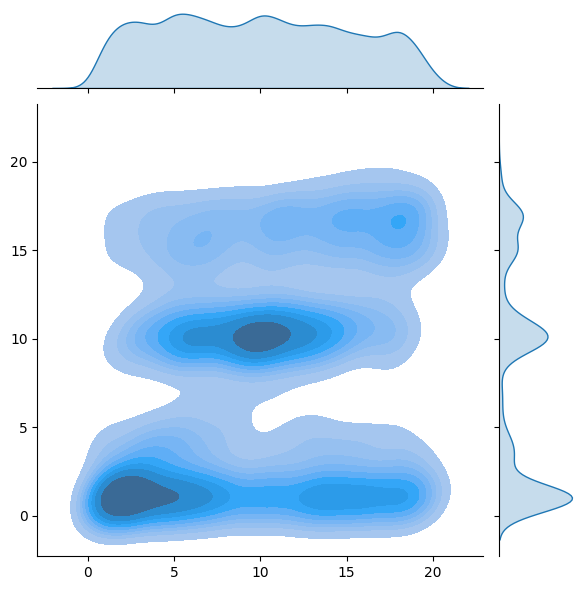

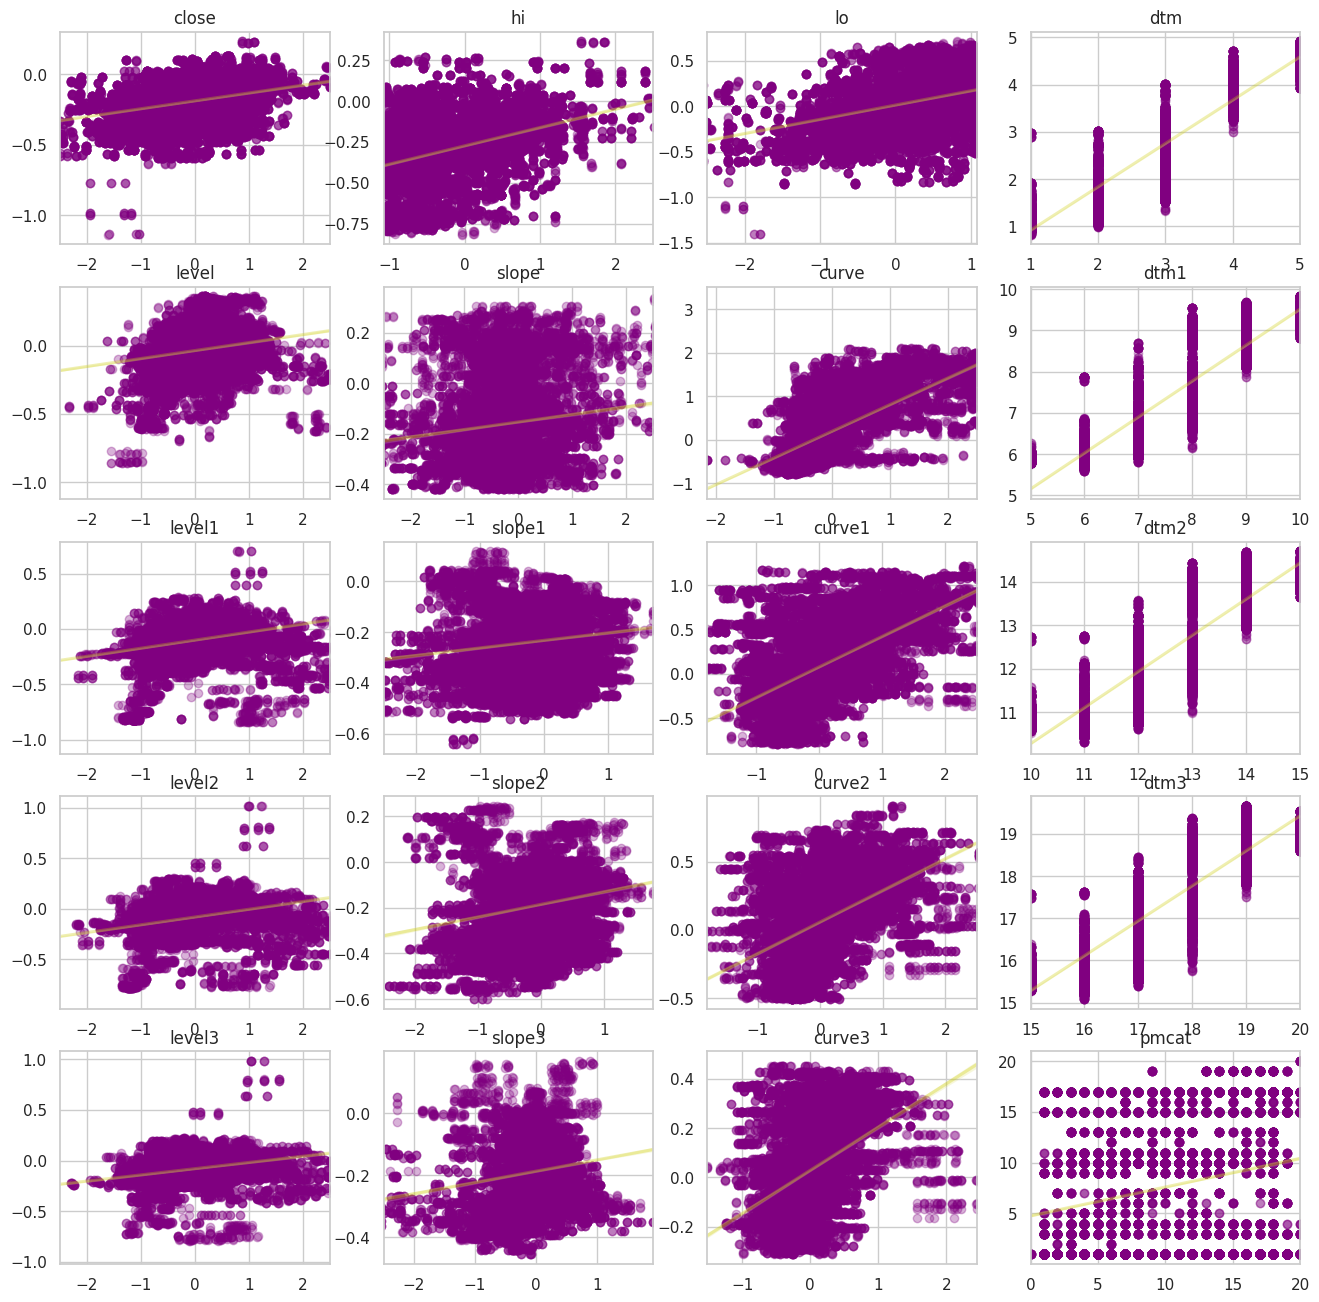

Epoch 020 | Validation score: 9.1589  <<< BEST VALIDATION EPOCH
Epoch 021 | Validation score: 9.0061  <<< BEST VALIDATION EPOCH
Epoch 022 | Validation score: 8.8869  <<< BEST VALIDATION EPOCH


In [ ]:
tables = ['volcvg.csv']
mydrive= 'E:/mydoc/git/trade/analyics/'
# """
tables = ['volcvN.csv','volcvT.csv','volcvA.csv','volcvG.csv']
from google.colab import drive
drive.mount('/content/drive')
mydrive='/content/drive/MyDrive/volrt/'
# Requirements:
import os
if not os.path.exists('/usr/local/lib/python3.10/dist-packages/rtdl'):
  %pip install git+https://github.com/jerronl/rtdl.git
#"""

appname='Xcj_'
duration = 6
bad_value=-99999
vars_h, cat_names, ys,vars_c,= (
    ['date', 'diff', 'spot'],
    [],
    [[
        'close', 'hi', 'lo',
        'dtm','level','slope','curve',
         'dtm1','level1','slope1','curve1',
         'dtm2','level2','slope2','curve2',
         'dtm3','level3','slope3','curve3'],
         [ 'pmcat',],],
    ['Horizon','spot','time'],
)
import numpy as np

vars_h+=ys[0]
dep_vars=ys#[duration]
# vars_c=vars_c[duration]

ignore_load_zero=ignore_load_error=y_std=y_mean=X=y=loss_fn=my_model=jobsize=offset=start_epoch=optimizer=rand_seed = None
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import rtdl.zero as zero
import matplotlib.pyplot as plt,os
%matplotlib inline
from typing import Optional
from torch import Tensor
import torch.nn as nn
import math
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from pickle import dump, load
import seaborn as sns
import random
from datetime import datetime
import calendar
import xlrd
from itertools import product
# !pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.13-cp38-cp38-linux_x86_64.whl --force-reinstall
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

device = torch.device('cuda')
zero.improve_reproducibility(seed=1234567)
batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*8
print(f'GPU mem:{int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)}G, batch_size:{batch_size}')

# =======================================================model=========================================
def cyclic_encode(data,feature,original,period,names):
  data[f'sin_{feature}'] = np.sin(2 * np.pi * original/period)
  data[f'cos_{feature}'] = np.cos(2 * np.pi * original/period)
  names.extend([f'sin_{feature}',f'cos_{feature}'])

def get_cont_names(next_run=None):
  cont_names, dfo  = [f'{x[0]}_{x[1]+1}' for x in product(vars_h,range(duration))], pd.DataFrame()
  for table in tables:
      df = pd.read_csv(mydrive + table)
      if next_run:
        df=df.query(f'date>"#{next_run}"')
      df['source']=table
      dfo = pd.concat([dfo, df])
  dfo.sort_values(by=['date'],inplace=True)
  for cyclic in ['date_1','date_2','date_3','date_4','date_5','date_6']:
    cyclics=np.vectorize(lambda x: x.timetuple())(pd.to_datetime(dfo[cyclic], unit='D', origin='1899-12-30').astype('object'))
    cyclic_encode(dfo,f'y_{cyclic}',cyclics[7]-1,
      np.vectorize(lambda x: 365-28+calendar.monthrange(x,2)[1])(cyclics[0]),
      cont_names)
    cyclic_encode(dfo,f'm_{cyclic}',cyclics[2]-1,
      np.vectorize(lambda x,y: calendar.monthrange(x,y)[1])(cyclics[0],cyclics[1]),
      cont_names)
    cyclic_encode(dfo,f'w_{cyclic}',cyclics[6],7,cont_names)
  for cyclic in ['diff_1','diff_2','diff_3','diff_4','diff_5','diff_6']:
    cyclic_encode(dfo,cyclic,dfo[cyclic],70,cont_names)
  for cyclic in ['dtm_1','dtm_2','dtm_3','dtm_4','dtm_5','dtm_6']:
    cyclic_encode(dfo,cyclic,dfo[cyclic],5,cont_names)
  cont_names.sort()
  for cyclic in ['date']:
    cyclics=np.vectorize(lambda x: datetime(int(x[1:5]),int(x[6:8]),int(x[9:11]),int(x[12:14]),int(x[15:17]),int(x[18:20]),).timetuple())(dfo[cyclic])
    cyclic_encode(dfo,f'y_{cyclic}',cyclics[7]-1,
      np.vectorize(lambda x: 365-28+calendar.monthrange(x,2)[1])(cyclics[0]),
      cont_names)
    cyclic_encode(dfo,f'm_{cyclic}',cyclics[2]-1,
      np.vectorize(lambda x,y: calendar.monthrange(x,y)[1])(cyclics[0],cyclics[1]),
      cont_names)
    cyclic_encode(dfo,f'w_{cyclic}',cyclics[6],7,cont_names)
  assert len(cont_names) % 6==0
  dfo['time']=np.modf(dfo['date_6'])[0]
  return dfo, cont_names

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, position=None):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        if position is None:
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
class PETrans(nn.Module):

    def __init__(self, duration, d_model,n_num_features,cat_cardinalities,d_out,x2):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        print("PETrans",duration, d_model,n_num_features,cat_cardinalities,d_out,x2)
        super().__init__()
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Linear(duration, d_model*2), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Dropout(0.1), #self.hparams.input_dropout),
            nn.GELU(), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Linear(d_model*2, d_model), # self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.unf=nn.Flatten(1,2)
        self.ftt= rtdl.FTTransformer.make_default(
            n_num_features=int(n_num_features/duration*d_model+x2),
            cat_cardinalities=cat_cardinalities,
            d_out=d_out,
            )

    def forward(self, x_num: Optional[Tensor], x_cat: Optional[Tensor], x2: Optional[Tensor]) -> Tensor:
        x = self.input_net(x_num)
        x = self.positional_encoding(x)
        x = self.unf(x)
        x = torch.cat((x, x2), 1)
        x = self.ftt(x, x_cat)
        return x

    def make_default_optimizer(self) -> torch.optim.AdamW:
        """Make the optimizer for the default FT-Transformer."""
        return self.ftt.make_default_optimizer()

def apply_model(model, x_num, x_cat=None, x2=None):
    return model(x_num, x_cat, x2)

@torch.no_grad()
def evaluate(mload=None,part='val'):
    model=mload or my_model
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], batch_size):
        prediction.append(apply_model(model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y[part]
    prediction2 = prediction[:,-y_cat:].argmax(1)
    mask = ~torch.isnan(target[:,:-1])
    score = (F.mse_loss(prediction[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
          ((target[:,-1]!=prediction2).sum()/len(prediction))

    return score,target, prediction,prediction2

def plot_result(target, prediction, prediction2, compare=False):
  sns.jointplot(x=target[:,-1] , y=prediction2,kind="kde",fill=True,rug=True)
  prediction[:,-y_cat]=prediction2
  sns.set(style="whitegrid")
  print(f'mse={np.mean((target[:,-1] - prediction2)**2)}')
  dep_var=dep_vars[0]+dep_vars[1]
  figs=min(len(dep_var),4)
  _, axes = plt.subplots(math.ceil(len(dep_var)/figs), figs, figsize=(16,16))
  for i,name in enumerate(dep_var):
      axs=axes.flat[i] if figs>1 else axes
      sns.regplot(ax=axs, x=target[:,i] , y=prediction[:,i],
                scatter_kws = {'color': 'purple', 'alpha': 0.3},
                line_kws = {'color': '#CCCC00', 'alpha': 0.3}
                )
      axs.set_title(name)
      mask=~np.isnan(target[:,i])
      if len(target[:,i][mask])>0:
        if not dep_var[i][:3] in ['dtm','pmc']:

          axs.set_xlim(left=max(np.min(target[:,i][mask]), -2.5),
                        right=min(np.max(target[:,i][mask]),2.5))
        else:
          axs.set_xlim(left=np.min(target[:,i][mask]),
                              right=np.max(target[:,i][mask]))
  plt.show()
  if compare:
    for i,name in enumerate(dep_var):
      if not dep_var[i][:3] in ['dtm','pmc']:
        plt.plot(target[:,i],label=f'actual {name}')
        plt.plot(prediction[:,i],label=f'forecast {name}')
        plt.legend()
        plt.show()

@torch.no_grad()
def validate(mload=None, threshold=10):
  score,target, prediction,prediction2 = evaluate(mload,'test')
  print(jobname,f'{score:.4f}')
  if score>threshold:
    return
  target, prediction, prediction2 = target.squeeze(1).cpu().numpy(), prediction.squeeze(1).cpu().numpy(), prediction2.cpu().numpy()
  plot_result(target, prediction,prediction2)

def cross_entropy_mse_loss_with_nans(input, target):
    mask = ~torch.isnan(target[:,:-1])
    return (F.mse_loss(input[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
      (F.cross_entropy (input[:,-y_cat:],target[:,-1].type(torch.LongTensor).to(device)))

def model_path():
  return mydrive+jobname+'checkpoint.pt'

def save_model(improved=False):
  path=mydrive+jobname+'checkpoint.pt'
  torch.save(
      {
          'model_':  my_model.state_dict() if improved or not os.path.exists(path) else
                    torch.load(path)['model_'],
          'model'       : my_model.state_dict(),
          'optimizer'   : optimizer.state_dict(),
          'epoch'       : epoch,
          'random_state': zero.random.get_state (),
          'jobsize'     : jobsize,
          'offset'      : offset,
          'rand_seed'    : rand_seed,
      },
      path
  )

def load_model(load_good=False,keep_seed=True):
  global jobsize,offset,start_epoch,my_model,optimizer,rand_seed
  start_epoch=1
  jobsize=int(len(X_all)*0.1)
  if resume:
    path=mydrive+jobname+'checkpoint.pt'
    if os.path.exists(path):
      try:
        checkpoint = torch.load(path,map_location=device)
        my_model.load_state_dict(checkpoint['model_'if load_good else 'model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        if 'rand_seed' in checkpoint and keep_seed:
          rand_seed=checkpoint['rand_seed']
        try:
          zero.random.set_state(checkpoint['random_state'])
        except (AssertionError,) as err:
          if ignore_load_zero:
            print("zero error:",err)
          else:
            raise err
        print(f'loaded {jobname} epoch {start_epoch}')
        if 'jobsize' in checkpoint and checkpoint['jobsize']<=jobsize:
          offset=checkpoint['offset']
          if checkpoint['jobsize']<jobsize:
            print('Job size increased from ', checkpoint['jobsize'], ' to ', jobsize)
            if offset<0:
              offset+=checkpoint['jobsize']*10
        else:
          raise ValueError('size diffs now',jobsize,
                checkpoint['jobsize'] if 'jobsize' in checkpoint else 0)
        return True
      except Exception as error:
        if ignore_load_error:
          print("failed to load: ", error)
        else:
          raise error
  random.seed(datetime.now().timestamp())
  offset=random.randint(-jobsize*3,-jobsize*2)+jobsize*10
  return False

def job_name():
  return appname+''.join(filter(lambda x: x not in "[' ", str(dep_vars[0])))[:8]

def setup_data(mis=False):
  global jobname,X,y, my_model,optimizer,train_loader,progress,y_mean,y_std,loss_fn,y_cat,rand_seed
  dep_var=dep_vars[0]+dep_vars[1]
  jobname=job_name()
  y_all=torch.tensor(dfo.loc[:,dep_var].to_numpy(), device=device)

  y_cat = 22#int(max(y_all[:,-1]))
  y_all[:,-1]-=1
  d_out = y_cat+y_all.shape[1]-1

  X,y = {},{}
  my_model=PETrans(
      duration=duration,
      d_model=16,
      n_num_features=len(cont_names),
      cat_cardinalities=[len(arr) for arr in enc.categories_],
      d_out=d_out,
      x2=len(vars_c)
      ).to(device)

  optimizer = (
      my_model.make_default_optimizer()
  )
  load_model(load_good=mis,keep_seed= not mis)

  X['train'], X['test'], y['train'], y['test']  = (
      np.concatenate((X_all[:offset],X_all[offset+jobsize:])),
      X_all[offset:offset+jobsize],
      torch.cat((y_all[:offset],y_all[offset+jobsize:])),
      y_all[offset:offset+jobsize],
  )
  if rand_seed is None:
    rand_seed=np.random.default_rng().integers(99999)
  print(jobname,y_all.shape,'offset ',offset,dfo['date'].iloc[offset],'seed', rand_seed)
  X['train'], X['val'],  y['train'], y['val']  = sklearn.model_selection.train_test_split(
      X['train'], y['train'], train_size=0.95, random_state=rand_seed
  )
  X2, X['test'], y2, y['test']  = sklearn.model_selection.train_test_split(
      X['test'], y['test'], train_size=0.05, random_state=rand_seed
  )
  X['val'], y['val']=np.concatenate((X['val'], X['test'])),torch.cat(( y['val'], y['test']))
  X['train'], y['train']=np.concatenate((X['train'], X2)),torch.cat(( y['train'], y2))

  X = {
      k: (torch.tensor(v[:,:len(cat_names)], device=device).to(torch.int64),
          torch.tensor(v[:,-len(cont_names):].reshape((v.shape[0],int(len(cont_names)/duration),duration)), device=device),
          torch.tensor(v[:,len(cat_names):-len(cont_names)], device=device),)
      for k, v in X.items()
  }
  # y = {k: torch.tensor(v, device=device) for k, v in y.items()}
  mask=torch.masked.masked_tensor(y['train'],y['train']!=bad_value)
  y_mean,y_std=mask.mean(dim=0).to_tensor(0),mask.std(dim=0).to_tensor(0)
  cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
  for k,v in y.items():
    v[v==bad_value]=float('nan')
    v[:,cols_to_norm]=((v-y_mean) / y_std)[:,cols_to_norm]
    y[k]=v


  y = {k: v.float() for k, v in y.items()}

  train_loader = zero.data.IndexLoader(len(X['train'][0]), batch_size, device=device)
  progress = zero.ProgressTracker(patience=100)
  loss_fn = cross_entropy_mse_loss_with_nans

def boxplot(vars,bad_value=None):
  i=j=min(5,len(vars))
  for _,var in enumerate(vars):
      if isinstance(var,list):
        y=pd.Series()
        for name in var:
          if name in dfo.columns:
            y=y.append(dfo[name],ignore_index = True)
      else:
        y=dfo[var] if var in dfo.columns else []
        name=var
      if len(y)>0:
        if i>=j:
          figure, axes = plt.subplots(1,j,figsize=(16,8))
          i=0
        axs=axes.flat[i]
        i+=1
        if bad_value is not None and y.min()<=bad_value:
          mask=y!=bad_value
          name=f'{name}_{mask.sum()/len(mask):.0%}'
          y=y[mask]
        sns.boxplot(ax=axs, y=y, showmeans=True,
                          meanprops={"marker": "+",
                        "markeredgecolor": "black",
                        "markersize": "10"})
        axs.set_title(name)
  plt.show()


def set_state(state: Dict[str, Any]) -> None:
    """Set global random states in `random`, `numpy` and `torch`.

    Args:
        state: global RNG states. Must be produced by `get_state`. The size of the list
            :code:`state['torch.cuda']` must be equal to the number of available cuda
            devices.

    See also:
        `get_state`

    Raises:
        AssertionError: if :code:`torch.cuda.device_count() != len(state['torch.cuda'])`
    """
    random.setstate(state['random'])
    np.random.set_state(state['numpy.random'])
    torch.random.set_rng_state(state['torch.random'].cpu())
    assert torch.cuda.device_count() == len(state['torch.cuda'])
    torch.cuda.set_rng_state_all([v.cpu() for v in state['torch.cuda']])  # type: ignore

zero.random.set_state=set_state

#====================================================train=================================
# next_dep = 0
# next_dep=1
# next_dep=2
# next_dep=3
resume = True  # False#
# tables = ['volcva.csv']
# tables = ['volcvN.csv','volcvT.csv','volcvA.csv','volcvG.csv']
dfo, cont_names=get_cont_names()

# dfo.sort_values(by=['date'],inplace=True)
enc = OrdinalEncoder()
dfo[cat_names] = enc.fit_transform(dfo[cat_names])
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')

print(dfo.shape, X_all.shape,len(dep_vars[0]))
zero_perc=(1-len(dfo[dfo['close']>0])/len(dfo)+len(dfo[dfo['close']<0])/len(dfo))/2
print(zero_perc,dfo['close'].quantile([0]+[i*(zero_perc-0.005)/9.5+0.005 for i in range(10)]+[0.995-(0.995-zero_perc)/10.5*(21-i) for i in range(11,22)]+[1]))
# boxplot(vars_h[1:],bad_value)
# boxplot([[f'{var}_{i+1}' for i in range(duration)] for var in vars_h[1:]],0)

#=====================================================run====================================
next_dep=0
# resume=False#s
# resume=True#False#
# ignore_load_error=True
# ignore_load_zero=True

n_epochs = 2000
n_trials = 80
start_epoch = 1
sub_epochs=15

for dep_sec in range(next_dep, len(dep_vars)):
    n_no_improve = 0
    setup_data()
    print(X['train'][0].shape, X['train'][1].shape, y['train'].shape)
    validate()
    resume=True
    # report_frequency = len(X['train']) // batch_size // 5
    for epoc in range(start_epoch, n_epochs , sub_epochs):
      for epoch in range(epoc,epoc+sub_epochs):
        for iteration, batch_idx in enumerate(train_loader):
            my_model.train()
            optimizer.zero_grad()
            x_batch = (X['train'][0][batch_idx] if len(cat_names)>0 else None,
                       X['train'][1][batch_idx],
                       X['train'][2][batch_idx])
            y_batch = y['train'][batch_idx]
            loss = loss_fn(
                apply_model(my_model,
                            x_cat=x_batch[0] if len(cat_names)>0 else None,
                            x_num=x_batch[1], x2=x_batch[2]).squeeze(1),
                y_batch)
            loss.backward()
            optimizer.step()
            # if iteration % report_frequency == 0:
            #     print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

        val_score = evaluate()[0]
        # test_score = evaluate(my_model,'test')[0]
        print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f}', end=" ")
        progress.update(-val_score)
        if progress.success:
            print(' <<< BEST VALIDATION EPOCH')
            save_model(True)
            n_no_improve = 0
        else:
            # save_model(False)
            n_no_improve += 1
            print(f' no improve {n_no_improve}')
        if progress.fail or val_score < .01 or n_no_improve > n_trials:
            break
      if progress.fail or val_score < .01 or n_no_improve > n_trials:
        break
      if n_no_improve>sub_epochs:
        setup_data()
    load_model()
    with open(mydrive + jobname, 'wb') as filehandler:
        dump((my_model, y_std, y_mean, enc), filehandler)
    validate()

# check

In [ ]:
      df=dfo[(dfo['date_6']>45225.6)&(dfo['date_6']<45225.7)&(dfo['date_5']>45224.6)&(dfo['date_5']<45224.7)&(dfo['Horizon']==1)&(dfo['spot']<-1.45)&(dfo['spot']>-1.46)]
      dep_var=dep_vars[0]+dep_vars[1]
      X, y = ({'test':
                (  # dfo.loc[:,cat_names+vars_c+cont_names].to_numpy().astype('float32')},{}
                    torch.tensor(df.loc[:, cat_names].to_numpy(), device=device).to(torch.int64),
                    torch.tensor(df.loc[:, cont_names].to_numpy().astype('float32').reshape((df.shape[0], int(len(cont_names) / duration), duration)), device=device),
                    torch.tensor(df.loc[:, vars_c].to_numpy().astype('float32'), device=device),
                )
                }, {'test': torch.tensor(df.loc[:,dep_var].to_numpy(), device=device).float()})
      print('duration: ', duration,df.shape, X['test'][0].shape, X['test'][1].shape, X['test'][2].shape)
      y['test'][:,-1]-=1

      #for learner in models:
      jobname = job_name()
      my_model, y_std, y_mean, enc = models
      y['test'][y['test']==bad_value]=float('nan')
      cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
      y['test'][:,cols_to_norm]=((y['test']-y_mean) / y_std)[:,cols_to_norm].float()
      score,target, prediction,prediction2 = evaluate(my_model,'test')
      print(score,target, prediction,prediction2 )

In [ ]:
torch.set_printoptions(precision=8)
X['test'][1][0]

In [ ]:
X['test'][1].shape,X['test'][2].shape

(torch.Size([2, 33, 6]), torch.Size([2, 2]))

# end

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
dfo[dfo['']]


In [ ]:
print(f"date_1:{X['test'][1][mini][0][0]} dtm:{target[mini][0]} diff_1:{X['test'][1][mini][1][0]} dtm_1:{X['test'][1][mini][6][0]}Horizon:{X['test'][2][mini][0]}")
dfo[(dfo['dtm']==int(target[mini][0]))&(dfo['date_1']>=int(X['test'][1][mini][0][0]*100-.5)/100.)&(dfo['date_1']<=int(X['test'][1][mini][0][0]*100+1)/100.)&(dfo['diff_1']==int(X['test'][1][mini][1][0]))&(dfo['dtm_1']==int(X['test'][1][mini][6][0]))&(dfo['Horizon']==int(X['test'][2][mini][0]))]

In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[(dfo['dtm']==int(target[mini][0]))&(dfo['date_1']>=int(X['test'][1][mini][0][0]*100-.5)/100.)&(dfo['date_1']<=int(X['test'][1][mini][0][0]*100+1)/100.)&(dfo['diff_1']==int(X['test'][1][mini][1][0]))&(dfo['dtm_1']==int(X['test'][1][mini][6][0]))&(dfo['Horizon']==int(X['test'][2][mini][0]))].iloc[10])

In [ ]:
sns.histplot( dfo[(dfo['Horizon']==0)]['close'])

In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(df.iloc[0])